# Chocolate Rating Analysis

## Web scraping data to then process, clean, etc. in the notebook.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

# from requests import get
# from bs4 import BeautifulSoup
# import pandas as pd
# from selenium import webdriver
# import chromedriver_autoinstaller
# def create_driver(headless=True):
#     driver = chromedriver_autoinstaller.install(cwd=True)
#     chrome_options = webdriver.ChromeOptions()     
#     if headless:
#         chrome_options.add_argument("--headless")
#     driver = webdriver.Chrome(driver, 
#                              chrome_options = chrome_options)
#     return driver
# driver = create_driver()

In [2]:
# driver.get("http://flavorsofcacao.com/chocolate_database.html")

In [3]:
# div_id = "spryregion1"

# html = driver.page_source
# soup = BeautifulSoup(html)
# div = soup.find('div', {'id':div_id})
# # div

# table = div.find('table')
# table


In [4]:
# pd.read_html(str(table))[0]

In [5]:
# df.to_csv('../../../data/chocolate.csv', index=False)

## Importing Necessary Python Libraries 

In [6]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import plot_confusion_matrix, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE

all_data = pd.read_csv('../../../data/chocolate.csv')
all_data.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50


## Data Cleaning 

### Replacing column spaces with underscores and lower casing column names for simplicity when calling them. 

In [7]:
#breaking away from original dataset and creating a copy to maintain the original structure as "all_data"
df = all_data.copy()

In [8]:
#removing parenthesis and spaces from columns 
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.lower()

#removing percent signs from row cocoa_percent
df = df.replace("%", "", regex=True)
# turning percentage of cocoa into a float
df["cocoa_percent"] = df.cocoa_percent.astype(float)

df.head()

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50


## Checking Feauture Felationships to Rating

### Inspecting the company location's weighted average in relation to rating

In [9]:
average_ratings_company_location = df.groupby('company_location')['rating'].mean().sort_values().to_dict()

In [10]:
company_location_counts = df['company_location'].value_counts(normalize=True).to_dict()

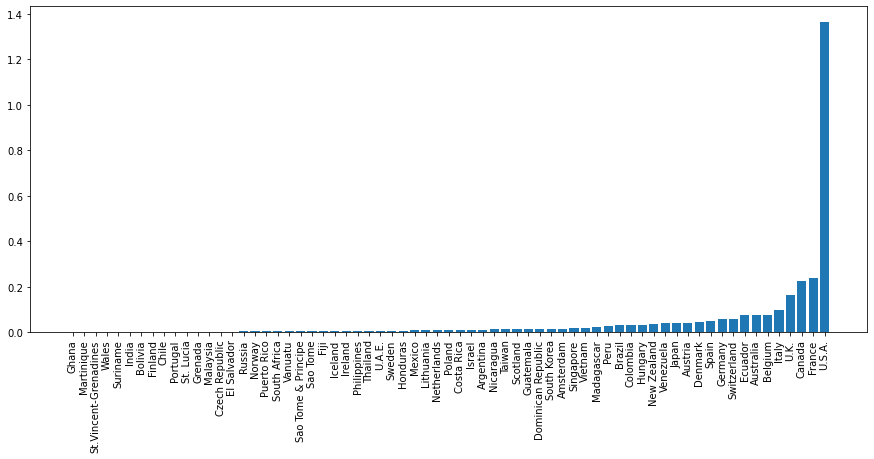

In [11]:
#creating a weighted average number of appearances * rating
import matplotlib.pyplot as plt
companies_loc = df.company_location.unique()
weighted_rating = []
for company in companies_loc:
    count = company_location_counts[company]
    rating = average_ratings_company_location[company]
    weighted_rating.append(count * rating)
    
sorted_vals = sorted(list(zip(weighted_rating, companies_loc)))
x = [val[1] for val in sorted_vals]
y = [val[0] for val in sorted_vals]

# Creating a vizualization for the relationships
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.xticks(rotation=90);

In [51]:
group_df = pd.DataFrame(list(zip(companies_loc, weighted_rating)), columns=['country', 'weighted_rating'])
group_df.head()

,country,weighted_rating
0,U.S.A.,1.364204
1,France,0.239522
2,Fiji,0.005504
3,Vanuatu,0.004657
4,Ecuador,0.074619


In [65]:
group_df['weighted_company_bins'] = pd.qcut(group_df['weighted_rating'], 
                                            labels=['low', 'middle', 'high'], q=3)

In [70]:
weighted_company_bins = group_df.set_index('country')['weighted_company_bins'].to_dict()

In [76]:
df['company_bins'] = df['company_location'].map(weighted_company_bins)

In [77]:
df

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,comp_location_bin,ingredient_list,company_bin,company_bins
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,1,"B,S,C",3,high
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,1,"B,S,C",3,high
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76.0,"3- B,S,C","rich cocoa, fatty, bready",3.25,1,"B,S,C",3,high
3,797,A. Morin,France,2012,Peru,Peru,63.0,"4- B,S,C,L","fruity, melon, roasty",3.75,1,"B,S,C,L",3,high
4,797,A. Morin,France,2012,Bolivia,Bolivia,70.0,"4- B,S,C,L","vegetal, nutty",3.50,1,"B,S,C,L",3,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1205,Zotter,Austria,2014,Blend,Raw,80.0,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75,b,"B,S*,C,Sa",2,high
2358,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75.0,"3- B,S,C","strong nutty, marshmallow",3.75,b,"B,S,C",2,high
2359,2170,Zotter,Austria,2018,Belize,Maya Mtn,72.0,"3- B,S,C","muted, roasty, accessible",3.50,b,"B,S,C",2,high
2360,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70.0,"3- B,S,C","fatty, mild nuts, mild fruit",3.25,b,"B,S,C",2,high


### Binning the company location's weighted average for one hot encoding

In [87]:
first_bin = x[:47]
df['comp_location_bin'] = 1

bin_a_index = df[df.company_location.isin(first_bin)].index
df.at[bin_a_index, 'comp_location_bin'] = 'a'

In [88]:
idx = x.index('Italy') + 1
second_bin = x[47:idx]

bin_b_index = df[df.company_location.isin(second_bin)].index
df.at[bin_b_index, 'comp_location_bin'] = 'b'

In [91]:
idx2 = x.index('U.K.')
third_bin = x[idx2:]

bin_c_index = df[df.company_location.isin(third_bin)].index
df.at[bin_c_index, 'comp_location_bin'] = 'c'

In [90]:
x[idx2:]

['U.K.', 'Canada', 'France', 'U.S.A.']

In [92]:
df.value_counts('comp_location_bin')

comp_location_bin
c    1411
b     570
a     250
dtype: int64

In [86]:
df[df.comp_location_bin == 1].company_location.unique()

array(['U.K.'], dtype=object)

In [38]:
company_bin = []
for c in df['company_location'].values:
    if c in first_bin:
        company_bin.append(1)
    elif c in second_bin:
        company_bin.append(2)
    else:
        company_bin.append(3)

In [40]:
df['company_bin'] = company_bin

<ipython-input-40-4a0a001afab5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_bin'] = company_bin


In [42]:
df['company_bin'].value_counts()

3    1411
2     570
1     250
Name: company_bin, dtype: int64

In [48]:
weighted_rating

[1.364204064352244,
 0.2395215918712955,
 0.005503810330228619,
 0.0046570702794242165,
 0.07461896697713802,
 0.010055038103302286,
 0.06033022861981372,
 0.010584250635055038,
 0.04974597798475868,
 0.004127857747671464,
 0.027307366638441997,
 0.2267146486028789,
 0.09980948348856901,
 0.03334038950042337,
 0.013124470787468248,
 0.16479678238780693,
 0.07535986452159188,
 0.006668077900084674,
 0.0011642675698560541,
 0.07758255715495344,
 0.021168501270110076,
 0.057049110922946664,
 0.01735817104149026,
 0.04085520745131245,
 0.0035986452159187127,
 0.014817950889077051,
 0.013124470787468248,
 0.004445385266723115,
 0.03344623200677392,
 0.04106689246401355,
 0.03672734970364098,
 0.011960203217612193,
 0.03386960203217612,
 0.01682895850973751,
 0.0140770533446232,
 0.0011642675698560541,
 0.004868755292125318,
 0.003492802709568162,
 0.012595258255715495,
 0.01418289585097375,
 0.0046570702794242165,
 0.014542760372565623,
 0.004762912785774767,
 0.0027519051651143096,
 0.0034

In [45]:
df.groupby('company_bin').mean()['weighted_rating']

KeyError: 'weighted_rating'

<BarContainer object of 2231 artists>

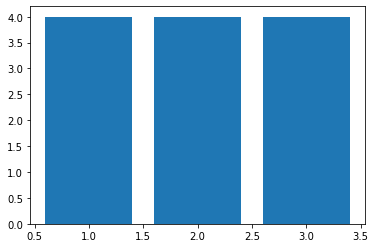

In [43]:
#creating a histogram to plot the data 


plt.bar(df['company_bin'], df['rating'])


### Removing the unnecissary information leading up to the ingredient names

In [29]:
# retreiving rows from the third index and on - leaving out rows with empty values
df['ingredient_list'] = [np.nan if l is np.nan else l[3:] for l in df['ingredients']]

### Inspecting the value (occurance count) and leaving out those with a low number of occurances

In [30]:
df['ingredient_list'].value_counts()

B,S,C          903
B,S            661
B,S,C,L        273
B,S,C,V,L      184
B,S,C,V        139
B,S*            31
B,S*,C,Sa       20
B,S*,C          12
B,S,L            8
B,S*,C,V         7
,S,C,V,Sa        6
B,S,V,L          5
B                5
B,S,C,Sa         5
,S,C,V,L,Sa      4
B,S,V            3
B,S*,V,L         3
B,S*,C,L         2
B,C              1
B,S*,Sa          1
B,S,C,L,Sa       1
Name: ingredient_list, dtype: int64

In [31]:
# leaving out occurances below 8 

most_common = (df['ingredient_list'].value_counts()).iloc[:9].index


df = df[df['ingredient_list'].isin(most_common)]


In [32]:
#ensuring that values below 8 were removed
df.ingredient_list.value_counts()

B,S,C        903
B,S          661
B,S,C,L      273
B,S,C,V,L    184
B,S,C,V      139
B,S*          31
B,S*,C,Sa     20
B,S*,C        12
B,S,L          8
Name: ingredient_list, dtype: int64

------

### -- Only use if we BREAK UP INGREDIENTS and MOST_MEM_CHAR --  Separating multiple into their own individual rows ----

In [ ]:
#placing each ingredient into a new list sepparated by commas

# df.most_memorable_characteristics = df.most_memorable_characteristics.str.split(',')


# df['split_ingredients'] = df['ingredient_list'].str.split(',')

# df = df.explode('split_ingredients')
# df = df.explode('most_memorable_characteristics')


------------

------------

In [33]:
df.head(2)

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating,comp_location_bin,ingredient_list
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76.0,"3- B,S,C","cocoa, blackberry, full body",3.75,1,"B,S,C"
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76.0,"3- B,S,C","cocoa, vegetal, savory",3.50,1,"B,S,C"


### Checking to see whether specific_bean_origin_or_bar_name is important or not

<AxesSubplot:>

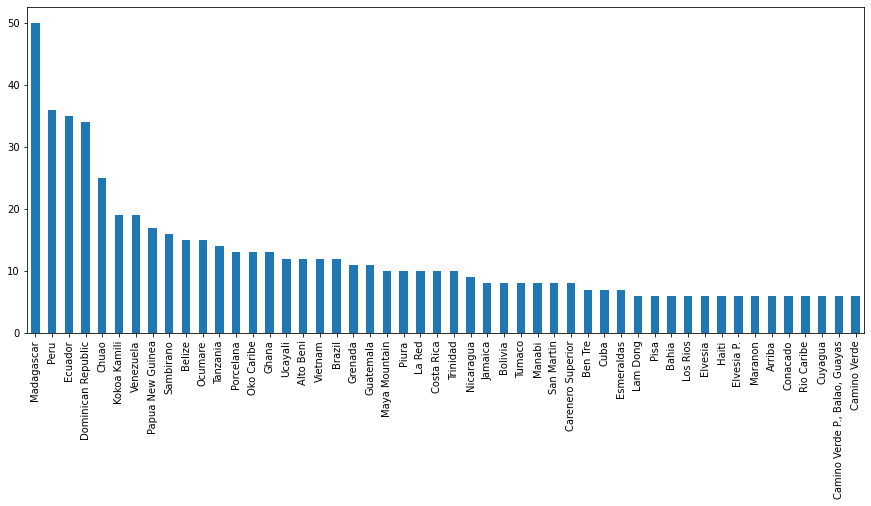

In [34]:
df['specific_bean_origin_or_bar_name'].value_counts()[:50].plot(kind='bar', figsize=(15,6))

### Clarifying important predictor values (x) for the target value (y).

In [56]:
# dropping the target (y) values from x and specific origin
features = df.drop(['rating','specific_bean_origin_or_bar_name', 'ingredients', 'review_date', 'ref'], axis =1)
X = features
y = df.rating


### Splitting the data into three subsets of training and validation data for the future models.
    Two train test splits create three subsets of the original dataset which allows for the training data to not be bled into the test data - this reduced model's bias towards the pre-existing testing data, thus assuring maximum performance on future test sets which the model has never been exposed. 

In [57]:
#performing train test split for test set (subsets 1/3)
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.15, random_state=42)


#performing a train test split for train and validation set (subsets - 3/3)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=42) 

In [58]:
#checking to ensure the shape of the columns and rows are still the same for the X and y values after the train test split.
X_tr.shape, y_tr.shape

((1896, 8), (1896,))

### Replacing any existing missing values  

In [59]:
#ingredients have 88 rows that have no imputs.
X_val.isna().sum()

company_manufacturer              0
company_location                  0
country_of_bean_origin            0
cocoa_percent                     0
most_memorable_characteristics    0
comp_location_bin                 0
ingredient_list                   0
company_bin                       0
dtype: int64

In [60]:
# the empty value replacement will be done using the most frequent fill strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X.columns)

X_val_imputed = pd.DataFrame(imputer.fit_transform(X_val),columns = X.columns)

In [61]:
#ensuring that the missing values from ingredients are now filled in with the most frequent occuring value

X_val_imputed.isna().sum()

company_manufacturer              0
company_location                  0
country_of_bean_origin            0
cocoa_percent                     0
most_memorable_characteristics    0
comp_location_bin                 0
ingredient_list                   0
company_bin                       0
dtype: int64

### Separating groups into numeric and catagorical data types 

In [ ]:
#taking a look at the groups data types to ensure that they are separated correctly
X_train.info()

In [ ]:
X_train_numeric 
X_train_cat

X_val_numerica

## Preprocessing:

In [ ]:
git fetch 

git merge/chandler